**Variable Screening and Transformation**

Goals:
- remove redundant covariates
- stabilize distributions
- produce a candidate set identical for all models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
df = pd.read_csv("/Users/inesschwartz/Desktop/training_data.csv")
df.head()

,X_coord,Y_coord,site_info_id,profile,district,geometry,landsurface_value,litho_value,formation,mean_temp_coldest_quarter,...,DEM,flow_accumulation,relief,ridge_levels,roughness,slope,TWI,valleydepth,faosoil_id,log_soc_stock
0,459336.209497,8.527991e+06,2400,113_57,Benguela,POINT (459336.209497001 8527990.762870297),2,2,113,18.200001,...,1116.9006,170716.20,9.055760,1897.4092,9.055760,2.677820,21.252900,780.508600,41.0,1.643861
1,692160.845254,8.462997e+06,2523,109_62,Bie,POINT (692160.845254297 8462996.974415973),2,2,113,16.600000,...,1583.8682,184287.77,18.363409,1622.8490,18.363409,3.495776,21.380291,38.980824,110.0,1.068040
2,604679.723785,8.395856e+06,2615,410_55,Huila,POINT (604679.7237846216 8395856.279717674),2,2,113,16.500000,...,1419.5433,8284751.00,127.713230,1573.6846,127.713230,2.879179,23.242464,154.141190,47.0,0.440282
3,736205.316190,8.452868e+06,2537,118_62,Bie,POINT (736205.316190272 8452867.693218533),1,1,113,16.299999,...,1506.2876,-49909.29,14.437837,1602.2160,14.437837,2.014339,21.308989,95.928310,104.0,0.986052
4,785664.442674,8.728324e+06,1714,111C_63,Malanje,POINT (785664.4426735085 8728324.346077582),1,1,97,18.700001,...,1232.9146,238993.12,25.479649,1413.0155,25.479649,2.751681,21.013489,180.100920,40.0,1.154745


In [3]:
# Drop the 'geometry' column
df = df.drop(columns=['geometry'])


In [4]:
print(df.X_coord.min(), df.X_coord.max())
print(df.Y_coord.min(), df.Y_coord.max())


174544.60741365992 1482544.1461838111
7998325.191518262 9508186.763478452


In [5]:
# (Optional) remove obviously redundant covariates
#    - constant columns
#    - perfectly correlated pairs

# Drop columns with a single unique value
constant_cols = [c for c in df.columns if df[c].nunique() <= 1]
df_reduced = df.drop(columns=constant_cols)

# Drop perfectly correlated columns (|r|=1.0)
corr_matrix = df_reduced.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
perfect_corr = [column for column in upper.columns if any(upper[column] == 1.0)]
# df_reduced = df_reduced.drop(columns=perfect_corr)

# Columns you want to retain even if flagged as perfectly correlated
keep_cols = [
    "aspect_sin",
    "TWI",
    "annual_mean_temp",
    "temp_annual_range",
    "temp_seasonality"
]

# Drop perfectly correlated columns except the ones you want to keep
perfect_corr_to_drop = [col for col in perfect_corr if col not in keep_cols]
df_reduced = df_reduced.drop(columns=perfect_corr_to_drop)


print("Dropped constant cols:", constant_cols)
print("Dropped perfectly correlated cols:", perfect_corr_to_drop)


Dropped constant cols: []
Dropped perfectly correlated cols: ['max_temp_warmest_month', 'mean_temp_driest_quarter', 'mean_temp_warmest_quarter', 'mean_temp_wettest_quarter', 'min_temp_coldest_month', 'roughness']


In [6]:
# ----------------------------
# 2. Numeric columns
# ----------------------------
numeric_cols = df_reduced.select_dtypes(include=[np.number]).columns

# ----------------------------
# 3. Output folder
# ----------------------------
out_dir = Path("/Users/inesschwartz/Desktop/training_eda_histograms")
out_dir.mkdir(parents=True, exist_ok=True)

# ----------------------------
# 4. Plot histograms in a grid
# ----------------------------
n_cols = 4  # columns in grid
n_rows = int(np.ceil(len(numeric_cols)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i], color="steelblue")
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(out_dir / "histograms_grid.png", dpi=150)
plt.close()
print(f"Histograms saved to: {out_dir}")

Histograms saved to: /Users/inesschwartz/Desktop/training_eda_histograms


In [7]:
df_reduced.columns

Index(['X_coord', 'Y_coord', 'site_info_id', 'profile', 'district',
       'landsurface_value', 'litho_value', 'formation',
       'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
       'isothermality', 'precip_coldest_quarter', 'precip_driest_month',
       'precip_driest_quarter', 'precip_seasonality', 'precip_warmest_quarter',
       'precip_wettest_month', 'precip_wettest_quarter', 'temp_annual_range',
       'temp_seasonality', 'MRVBF', 'RLD', 'aspect', 'aspect_cos',
       'aspect_sin', 'DEM', 'flow_accumulation', 'relief', 'ridge_levels',
       'slope', 'TWI', 'valleydepth', 'faosoil_id', 'log_soc_stock'],
      dtype='object')

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

df_reduced

# ----------------------------
# 2. List topographic / DEM-derived columns
# ----------------------------
topo_cols = [
    "MRVBF",
    "RLD",
    "aspect",
    "aspect_cos",
    "aspect_sin",
    "slope",
    "TWI",
    "valleydepth",
    "ridge_levels",
    "DEM",
    "flow_accumulation"
]

# ----------------------------
# 3. Replace known NoData placeholders with NaN
# ----------------------------
nodata_values = [-99999, -9999, -999, 99999, 9999]  # extend if needed
for col in topo_cols:
    df_reduced[col] = df_reduced[col].replace(nodata_values, np.nan)

# ----------------------------
# 4. Clip outliers based on percentiles
# ----------------------------
def clip_outliers(series, lower_pct=1, upper_pct=99):
    lower = np.percentile(series.dropna(), lower_pct)
    upper = np.percentile(series.dropna(), upper_pct)
    return series.clip(lower, upper)

for col in topo_cols:
    df_reduced[col] = clip_outliers(df_reduced[col], lower_pct=1, upper_pct=99)

# ----------------------------
# 5. Optional: plot histograms after clipping
# ----------------------------
out_dir = Path("/Users/inesschwartz/Desktop/topo_histograms")
out_dir.mkdir(parents=True, exist_ok=True)

for col in topo_cols:
    plt.figure(figsize=(5,4))
    sns.histplot(df[col].dropna(), bins=30, kde=True, color='steelblue')
    plt.title(f"Histogram of {col} (clipped)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(out_dir / f"hist_{col}.png", dpi=150)
    plt.close()

print(f"Clipping done. Histograms saved in: {out_dir}")

# ----------------------------
# 6. Save cleaned dataset
# ----------------------------
clean_csv_path = "/Users/inesschwartz/Desktop/training_data_topo_cleaned.csv"
df_reduced.to_csv(clean_csv_path, index=False)
print(f"Cleaned CSV saved: {clean_csv_path}")


Clipping done. Histograms saved in: /Users/inesschwartz/Desktop/topo_histograms
Cleaned CSV saved: /Users/inesschwartz/Desktop/training_data_topo_cleaned.csv


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# 1. Load training data
# ----------------------------
csv_path = "/Users/inesschwartz/Desktop/training_data_topo_cleaned.csv"
df = pd.read_csv(csv_path)

# ----------------------------
# 2. List bioclimatic variables
# ----------------------------
bioclim_cols = [
    'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
    'isothermality', 'precip_coldest_quarter',
    'precip_driest_month', 'precip_driest_quarter', 'precip_seasonality',
    'precip_warmest_quarter', 'precip_wettest_month',
    'precip_wettest_quarter', 'temp_annual_range',
    'temp_seasonality'
]

# ----------------------------
# 3. Replace extreme placeholder values with NaN
# ----------------------------
# thresholds based on plausible ranges for temperature (°C) and precipitation (mm)
for col in bioclim_cols:
    df[col] = df[col].apply(lambda x: np.nan if x < -1e5 or x > 1e5 else x)

# ----------------------------
# 4. Function for percentile-based clipping
# ----------------------------
def clip_percentiles(series, lower=1, upper=99):
    series_clean = series.dropna()
    lower_val, upper_val = np.percentile(series_clean, [lower, upper])
    return series.clip(lower_val, upper_val)

# ----------------------------
# 5. Plot and save histograms
# ----------------------------
out_dir = Path("/Users/inesschwartz/Desktop/bioclim_histograms")
out_dir.mkdir(parents=True, exist_ok=True)

for col in bioclim_cols:
    clipped = clip_percentiles(df[col])
    plt.figure(figsize=(5,4))
    sns.histplot(clipped, bins=30, kde=True, color='darkgreen')
    plt.title(f"Histogram of {col} (clipped 1-99%)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(out_dir / f"hist_{col}.png", dpi=150)
    plt.close()

print(f"Bioclimatic histograms saved in: {out_dir}")

# ----------------------------
# 6. Save cleaned dataset
# ----------------------------
clean_csv_path = "/Users/inesschwartz/Desktop/training_data_bioclim_cleaned.csv"
df.to_csv(clean_csv_path, index=False)
print(f"Cleaned bioclim dataset saved: {clean_csv_path}")


Bioclimatic histograms saved in: /Users/inesschwartz/Desktop/bioclim_histograms
Cleaned bioclim dataset saved: /Users/inesschwartz/Desktop/training_data_bioclim_cleaned.csv


In [10]:
df.columns

Index(['X_coord', 'Y_coord', 'site_info_id', 'profile', 'district',
       'landsurface_value', 'litho_value', 'formation',
       'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
       'isothermality', 'precip_coldest_quarter', 'precip_driest_month',
       'precip_driest_quarter', 'precip_seasonality', 'precip_warmest_quarter',
       'precip_wettest_month', 'precip_wettest_quarter', 'temp_annual_range',
       'temp_seasonality', 'MRVBF', 'RLD', 'aspect', 'aspect_cos',
       'aspect_sin', 'DEM', 'flow_accumulation', 'relief', 'ridge_levels',
       'slope', 'TWI', 'valleydepth', 'faosoil_id', 'log_soc_stock'],
      dtype='object')

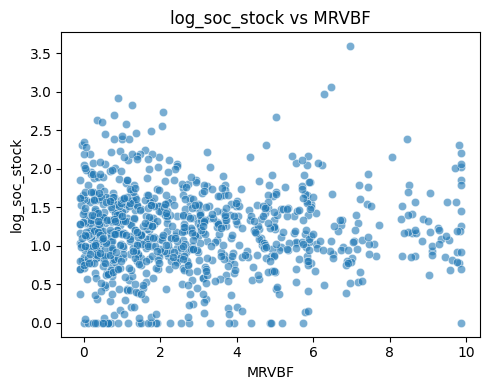

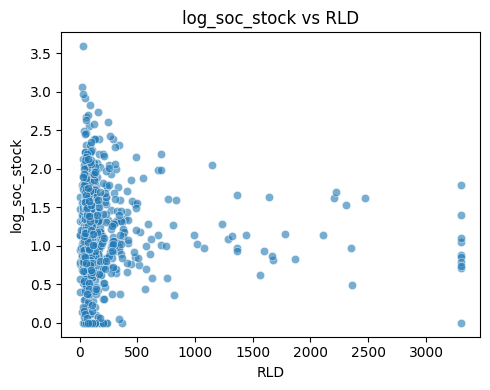

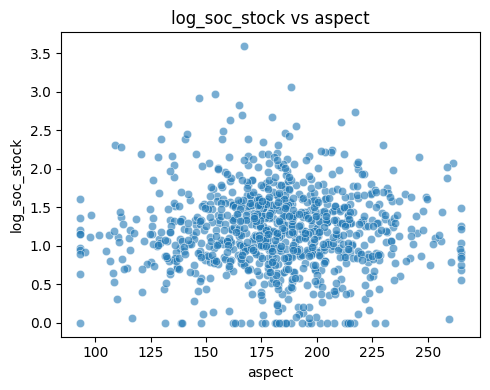

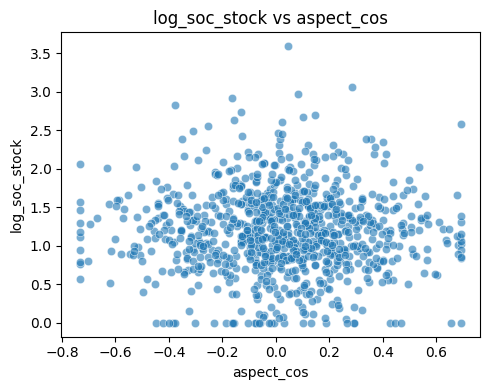

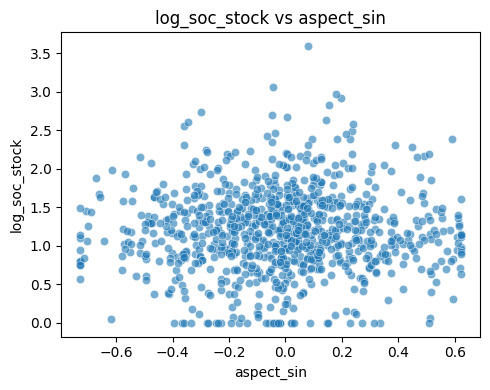

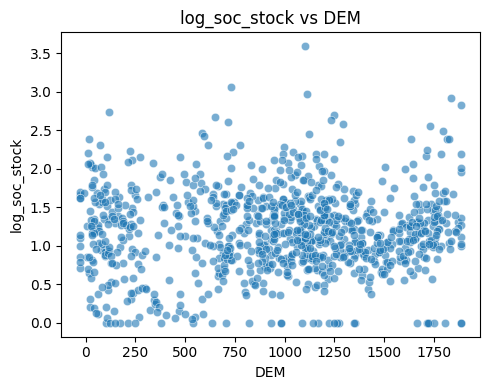

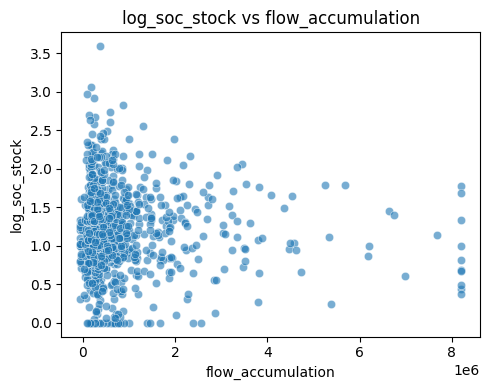

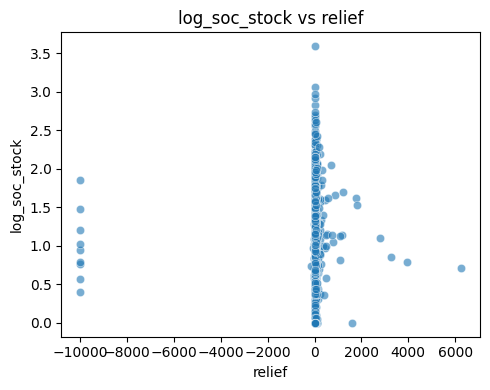

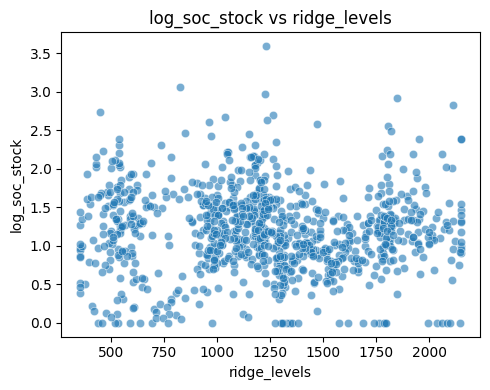

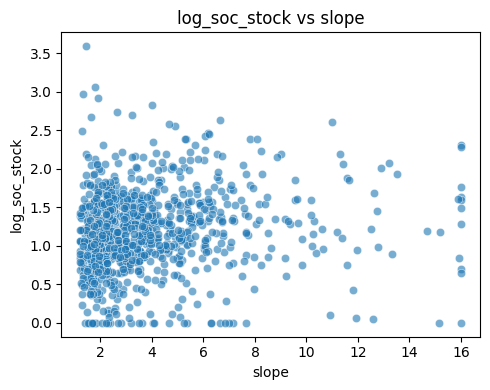

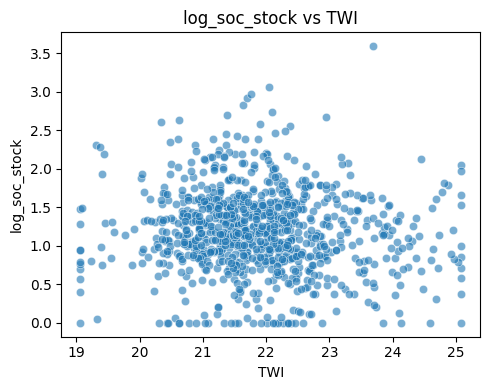

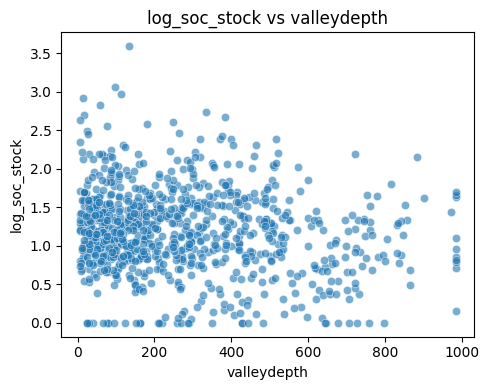

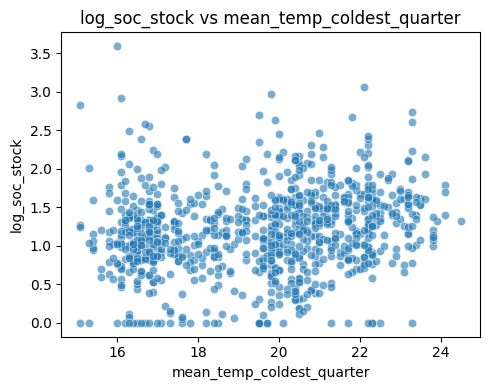

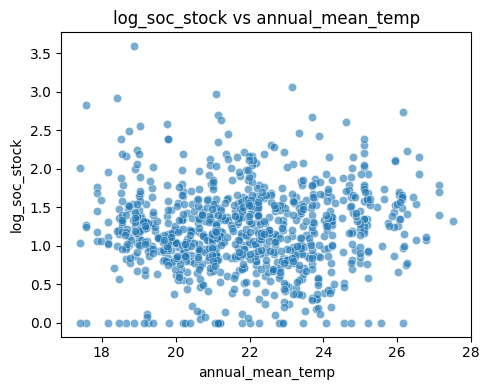

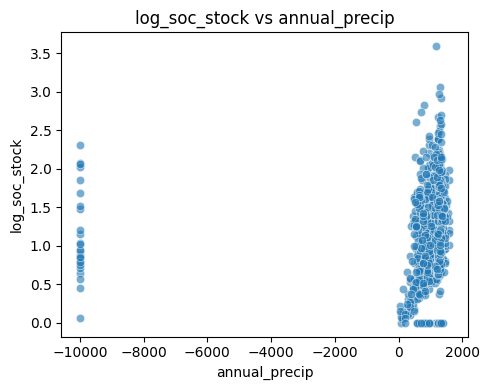

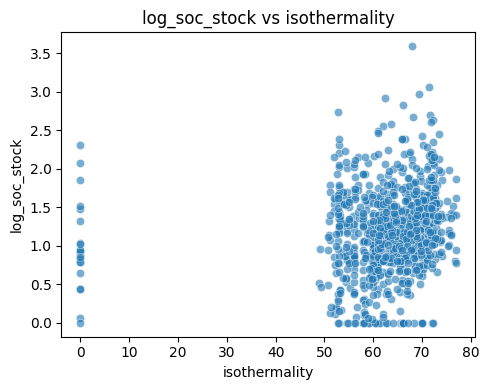

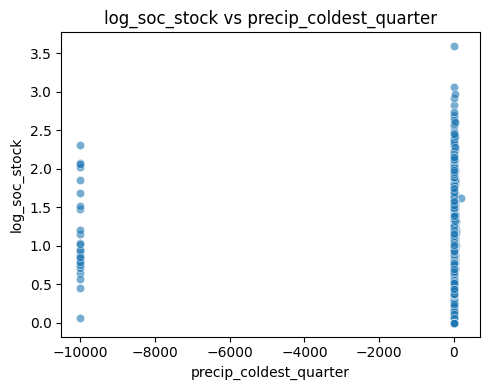

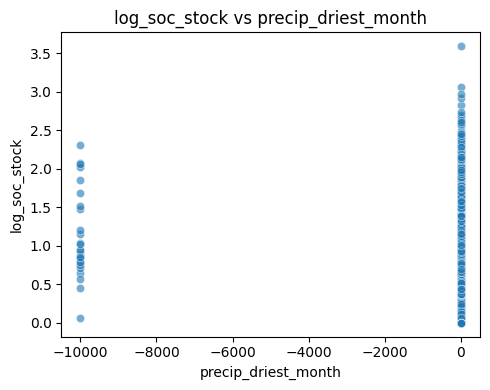

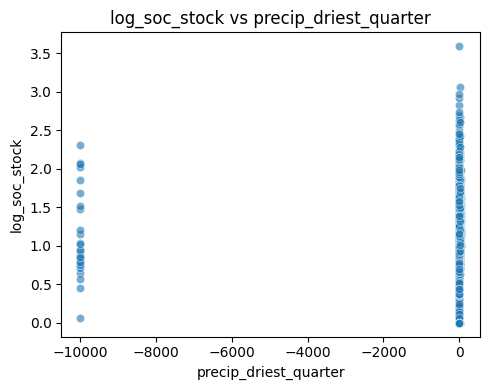

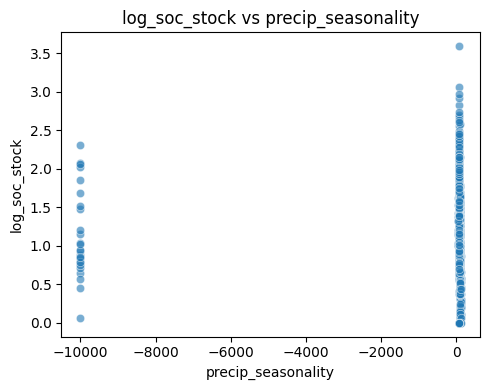

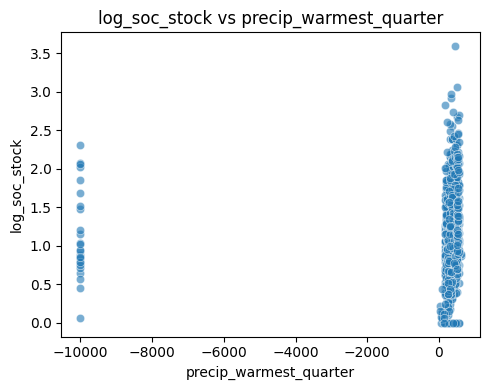

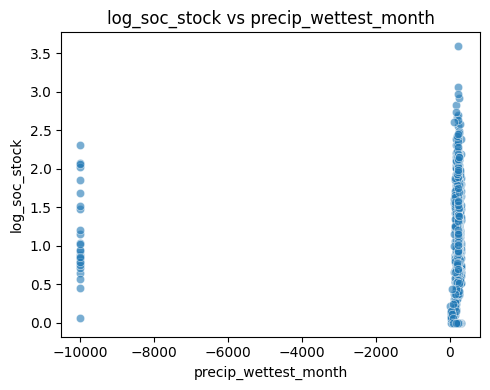

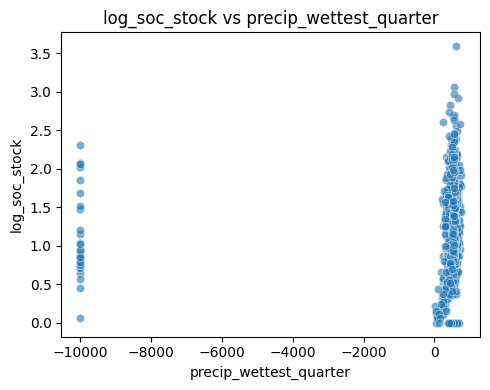

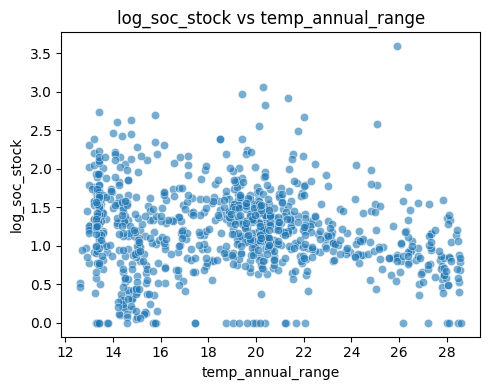

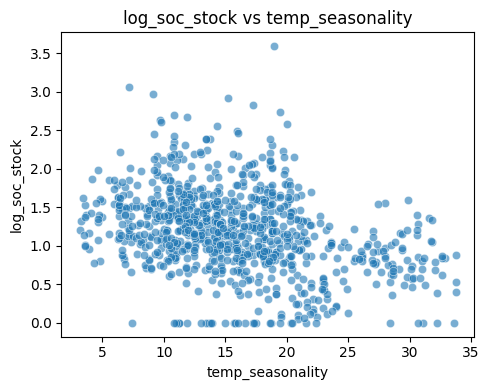

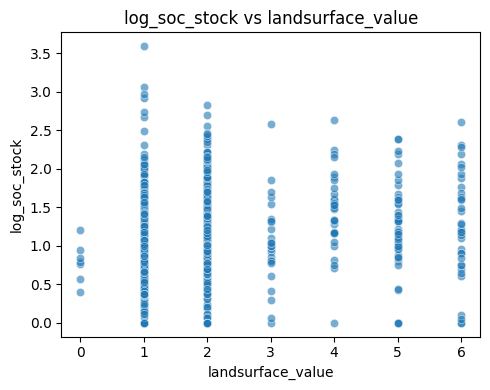

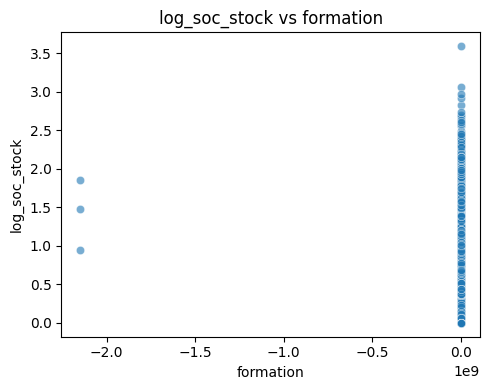

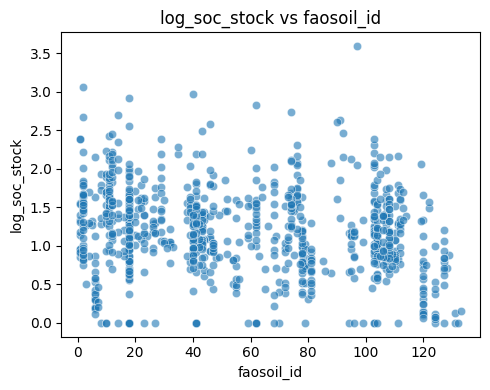

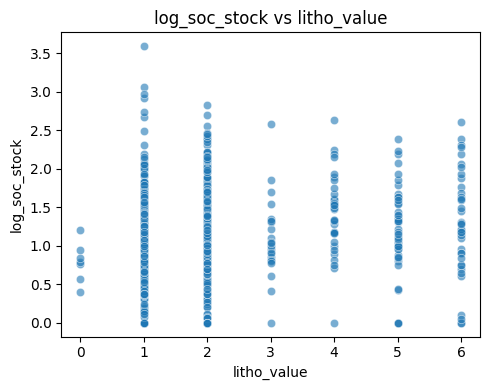

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric covariates
numeric_cols = [
    'MRVBF', 'RLD', 'aspect', 'aspect_cos', 'aspect_sin', 'DEM', 'flow_accumulation',
    'relief', 'ridge_levels', 'slope', 'TWI', 'valleydepth',
    'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
    'isothermality', 'precip_coldest_quarter', 'precip_driest_month',
    'precip_driest_quarter', 'precip_seasonality', 'precip_warmest_quarter',
    'precip_wettest_month', 'precip_wettest_quarter',
    'temp_annual_range', 'temp_seasonality', 'landsurface_value',
    'formation', 'faosoil_id', 'litho_value'
]

# Create scatter plots vs log_soc_stock
for col in numeric_cols:
    plt.figure(figsize=(5,4))
    sns.scatterplot(data=df, x=col, y='log_soc_stock', alpha=0.6)
    plt.title(f"log_soc_stock vs {col}")
    plt.xlabel(col)
    plt.ylabel("log_soc_stock")
    plt.tight_layout()
    plt.show()


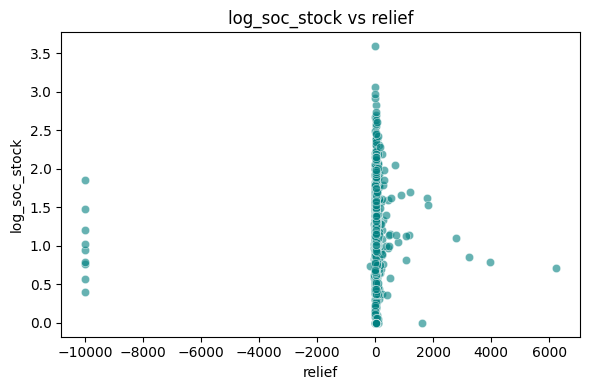

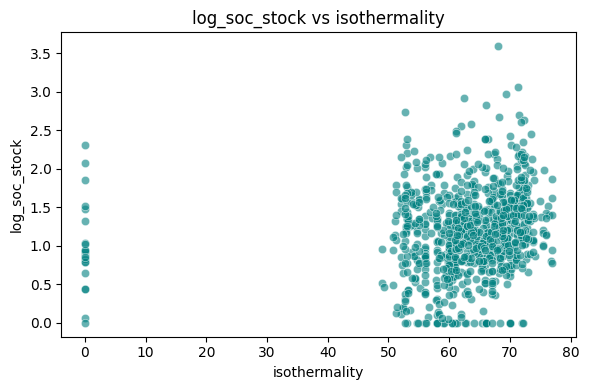

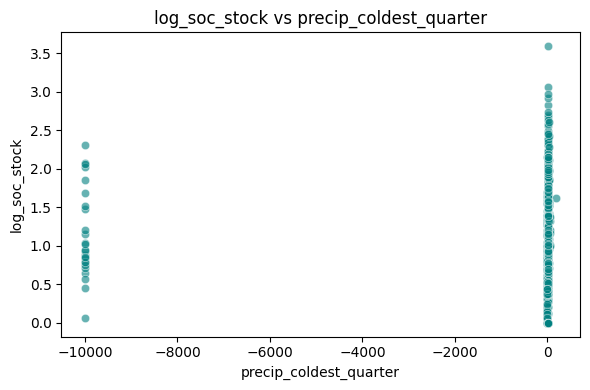


relief potential outliers (below 1st pct or above 99th pct):
     site_info_id      relief  log_soc_stock
203            56 -9999.00000       1.849645
212            30 -9999.00000       1.481910
214            58 -9999.00000       0.764571
256          3233  1080.45040       0.815282
276          3556 -9999.00000       0.403182
281          3641 -9999.00000       0.790544
282          3644 -9999.00000       0.949267
285          3325  6250.73240       0.706684
297          3608  1616.95560       0.000000
304          3069  3243.39820       0.853072
305          3304  3949.86700       0.796138
487          1718  1163.06340       1.135434
507          2767 -9999.00000       0.571339
525           529  1779.16830       1.617655
544           619  2788.83890       1.105922
594           722  1830.77930       1.531594
734          1213  -169.76166       0.736779
792           297  1194.98750       1.696250
847           255 -9999.00000       1.023427
890           409 -9999.00000       1.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables to inspect
vars_to_check = ['relief', 'isothermality', 'precip_coldest_quarter']

# Scatter plots with log_soc_stock
for col in vars_to_check:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=col, y='log_soc_stock', alpha=0.6, color='teal')
    plt.title(f"log_soc_stock vs {col}")
    plt.xlabel(col)
    plt.ylabel("log_soc_stock")
    plt.tight_layout()
    plt.show()

# ----------------------------
# Flag potential outliers (1st and 99th percentiles)
# ----------------------------
for col in vars_to_check:
    lower, upper = df[col].quantile([0.01, 0.99])
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"\n{col} potential outliers (below 1st pct or above 99th pct):")
    print(outliers[['site_info_id', col, 'log_soc_stock']])
    print(f"Number of potential outliers: {len(outliers)}")


In [13]:
# weird values:
# Replace placeholder NoData values with NaN.
df['relief'] = df['relief'].replace(-9999, np.nan)


In [14]:
df.columns

Index(['X_coord', 'Y_coord', 'site_info_id', 'profile', 'district',
       'landsurface_value', 'litho_value', 'formation',
       'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
       'isothermality', 'precip_coldest_quarter', 'precip_driest_month',
       'precip_driest_quarter', 'precip_seasonality', 'precip_warmest_quarter',
       'precip_wettest_month', 'precip_wettest_quarter', 'temp_annual_range',
       'temp_seasonality', 'MRVBF', 'RLD', 'aspect', 'aspect_cos',
       'aspect_sin', 'DEM', 'flow_accumulation', 'relief', 'ridge_levels',
       'slope', 'TWI', 'valleydepth', 'faosoil_id', 'log_soc_stock'],
      dtype='object')

## standardize to z score (necessary for regression kriging)

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# -------------------------------------------
# 1. Identify continuous variables to scale
# -------------------------------------------
continuous_cols = [
    'MRVBF', 'RLD', 'aspect', 'aspect_cos', 'aspect_sin', 'DEM',
    'flow_accumulation', 'relief', 'ridge_levels', 'slope', 'TWI',
    'valleydepth', 'mean_temp_coldest_quarter', 'annual_mean_temp',
    'annual_precip', 'isothermality', 'precip_coldest_quarter',
    'precip_driest_month', 'precip_driest_quarter', 'precip_seasonality',
    'precip_warmest_quarter', 'precip_wettest_month', 'precip_wettest_quarter',
    'temp_annual_range', 'temp_seasonality'
    # SOC target is excluded
]

# -------------------------------------------
# 2. Fit–transform with StandardScaler
# -------------------------------------------
scaler = StandardScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# -------------------------------------------
# 3. Keep categorical variables as-is
# -------------------------------------------
# Ensure they’re stored as categories (optional but recommended)
categorical_cols = ['litho_value', 'formation', 'landsurface_value']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# (Optional) confirm result
print(df[continuous_cols].describe().T[['mean', 'std']].head())
print(df[categorical_cols].dtypes)


                    mean       std
MRVBF       7.571357e-17  1.000547
RLD         5.207561e-17  1.000543
aspect     -4.900963e-16  1.000546
aspect_cos -1.157236e-17  1.000543
aspect_sin  3.857452e-18  1.000543
litho_value          category
formation            category
landsurface_value    category
dtype: object


## redundancy detection

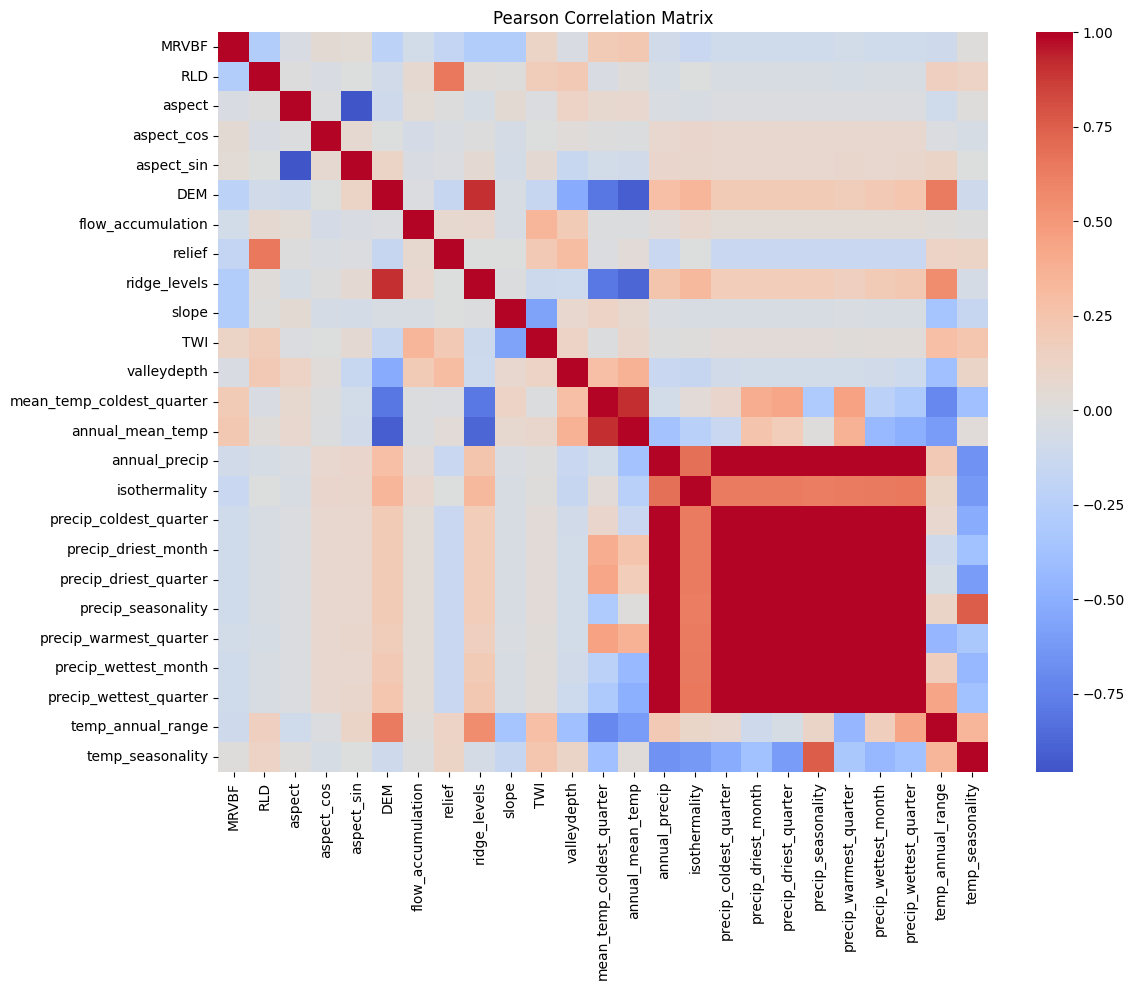

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -------------------------------------------
# 1. Define continuous predictors
# -------------------------------------------
cont_cols = [
    'MRVBF','RLD','aspect','aspect_cos','aspect_sin','DEM',
    'flow_accumulation','relief','ridge_levels','slope','TWI','valleydepth',
    'mean_temp_coldest_quarter','annual_mean_temp','annual_precip','isothermality',
    'precip_coldest_quarter','precip_driest_month','precip_driest_quarter',
    'precip_seasonality','precip_warmest_quarter','precip_wettest_month',
    'precip_wettest_quarter','temp_annual_range','temp_seasonality'
]

# -------------------------------------------
# 2. Pearson correlation matrix
# -------------------------------------------
corr = df[cont_cols].corr(method="pearson")

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()


In [17]:
# -------------------------------------------
# 3. Variance Inflation Factor (VIF)
# -------------------------------------------
X = df[cont_cols].dropna()  # VIF requires no missing values
vif_df = pd.DataFrame({
    "variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)

print("\nVariance Inflation Factors:")
print(vif_df)



Variance Inflation Factors:
                     variable           VIF
17        precip_driest_month  11029.628614
18      precip_driest_quarter   8223.493560
19         precip_seasonality   5236.745248
16     precip_coldest_quarter   1963.665649
12  mean_temp_coldest_quarter    760.903150
13           annual_mean_temp    622.267760
21       precip_wettest_month    440.041778
5                         DEM    294.805709
22     precip_wettest_quarter    254.077000
8                ridge_levels    218.193266
24           temp_seasonality    140.625111
14              annual_precip    119.538769
11                valleydepth     53.780220
20     precip_warmest_quarter     21.779617
4                  aspect_sin     12.900831
2                      aspect     12.756491
23          temp_annual_range      7.457057
7                      relief      2.725637
15              isothermality      2.631991
10                        TWI      2.416727
1                         RLD      2.093810
9  

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import pandas as pd

#------------------------------------------------------
# 1. Define your working copy
#------------------------------------------------------
df_reduced = df.copy()

# --- Precipitation metrics: keep only annual_precip
drop_precip = [
    'precip_driest_quarter',
    'precip_wettest_quarter',
    'precip_coldest_quarter',
    'precip_warmest_quarter',
]

# --- Temperature metrics: keep annual_mean_temp + temp_annual_range
drop_temp = [
    'mean_temp_coldest_quarter',
]

# --- Topography: keep DEM as master, drop ridge_levels
drop_topo = ['ridge_levels']

# --- Aspect: keep cosine & sine encoding only
#drop_aspect = ['aspect']  # drop raw aspect

# Combine all to drop
drop_list = drop_precip + drop_temp + drop_topo

df_reduced = df_reduced.drop(columns=[c for c in drop_list if c in df_reduced.columns])

In [19]:
df_reduced.columns

Index(['X_coord', 'Y_coord', 'site_info_id', 'profile', 'district',
       'landsurface_value', 'litho_value', 'formation', 'annual_mean_temp',
       'annual_precip', 'isothermality', 'precip_driest_month',
       'precip_seasonality', 'precip_wettest_month', 'temp_annual_range',
       'temp_seasonality', 'MRVBF', 'RLD', 'aspect', 'aspect_cos',
       'aspect_sin', 'DEM', 'flow_accumulation', 'relief', 'slope', 'TWI',
       'valleydepth', 'faosoil_id', 'log_soc_stock'],
      dtype='object')

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_3809/3175253987.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.arrow(0, 0, loadings.PC1[i]*5, loadings.PC2[i]*5, color='red', alpha=0.7, head_width=0.2)
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_3809/3175253987.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(loadings.PC1[i]*5.2, loadings.PC2[i]*5.2, var, color='black', fontsize=9)


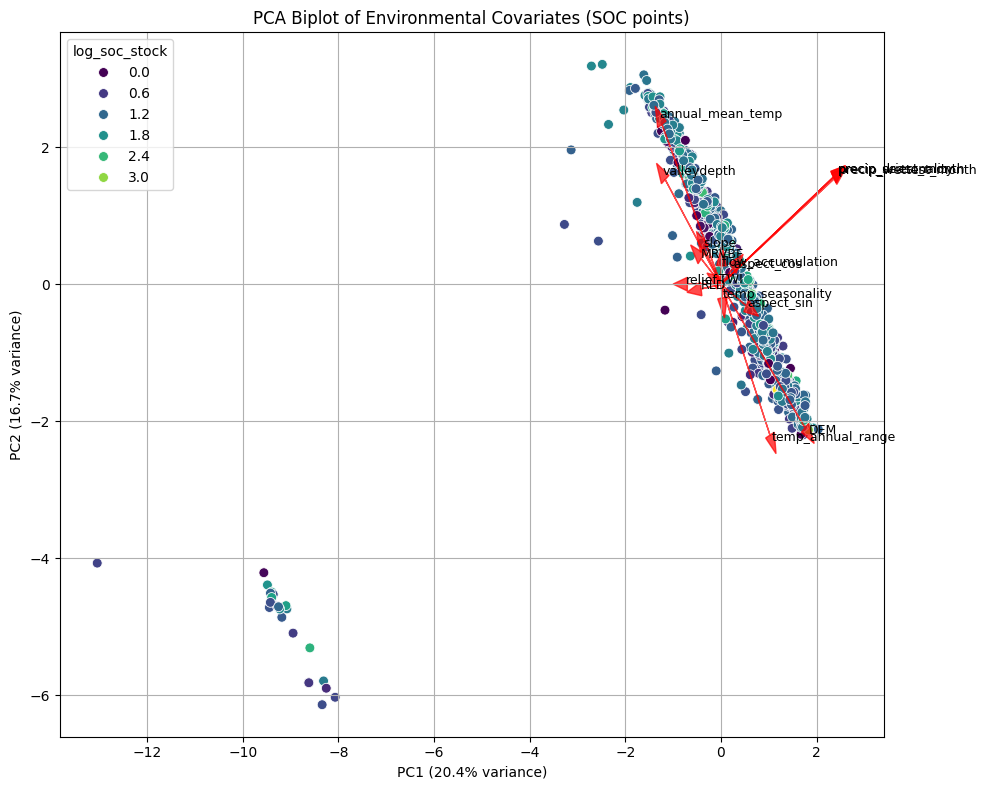

Variable loadings on first two PCs:
                            PC1       PC2
MRVBF                -0.082683  0.074903
RLD                  -0.083051 -0.013490
aspect_cos            0.049271  0.046761
aspect_sin            0.105600 -0.062554
DEM                   0.351388 -0.418772
flow_accumulation     0.002108  0.054453
relief               -0.140591  0.000600
slope                -0.069431  0.104616
TWI                  -0.006621  0.003720
valleydepth          -0.233325  0.305955
annual_mean_temp     -0.247060  0.467254
precip_driest_month   0.470747  0.313267
precip_wettest_month  0.473415  0.308566
precip_seasonality    0.470491  0.313448
temp_annual_range     0.204887 -0.440160
temp_seasonality      0.005858 -0.039241


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1. Select numeric continuous covariates
# ------------------------------
continuous_covs = [
    'MRVBF', 'RLD', 'aspect_cos', 'aspect_sin', 'DEM', 'flow_accumulation',
    'relief', 'slope', 'TWI', 'valleydepth',
    'annual_mean_temp', 'precip_driest_month', 'precip_wettest_month', 'precip_seasonality',
    'temp_annual_range', 'temp_seasonality'
]

df_pca = df[continuous_covs].copy()
df_pca = df_pca.fillna(df_pca.median())  # handle missing values

# ------------------------------
# 2. Standardize the data
# ------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)

# ------------------------------
# 3. PCA
# ------------------------------
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
pc_df = pd.DataFrame(data=pcs, columns=['PC1', 'PC2'])
pc_df['log_soc_stock'] = df['log_soc_stock'].values

# ------------------------------
# 4. Biplot
# ------------------------------
plt.figure(figsize=(10,8))

# Scatter points colored by SOC stock
sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='log_soc_stock', palette='viridis', s=50)

# Add arrows for variable loadings
loadings = pd.DataFrame(pca.components_.T, index=continuous_covs, columns=['PC1', 'PC2'])
for i, var in enumerate(loadings.index):
    plt.arrow(0, 0, loadings.PC1[i]*5, loadings.PC2[i]*5, color='red', alpha=0.7, head_width=0.2)
    plt.text(loadings.PC1[i]*5.2, loadings.PC2[i]*5.2, var, color='black', fontsize=9)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('PCA Biplot of Environmental Covariates (SOC points)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# 5. Optional: print loadings
# ------------------------------
print("Variable loadings on first two PCs:\n", loadings)


In [21]:
df_reduced.head()
df_reduced.to_csv("/Users/inesschwartz/Desktop/model_training_data.csv")

In [22]:
# Count number of log_soc_stock == 0
num_zeros = (df_reduced['log_soc_stock'] == 0).sum()
print("Number of log_soc_stock values equal to 0:", num_zeros)

# Optionally, view these rows
zeros_df = df_reduced[df_reduced['log_soc_stock'] == 0]
print(zeros_df)


Number of log_soc_stock values equal to 0: 31
          X_coord       Y_coord  site_info_id  profile        district  \
28   6.736661e+05  8.711966e+06          1783   207_61             Bie   
49   6.574965e+05  8.613774e+06          2121   323_62             Bie   
83   4.357616e+05  8.542989e+06          2346   119_57        Benguela   
85   4.295836e+05  8.546962e+06          2338   121_57        Benguela   
114  5.140515e+05  8.563548e+06          2290   199_57        Benguela   
135  4.696504e+05  8.564850e+06          2285   229_57        Benguela   
149  5.180533e+05  8.636757e+06          2037   249_57        Benguela   
163  4.226592e+05  8.569377e+06          2268   274_57        Benguela   
199  2.485386e+05  9.488118e+06            17   100_59         Cabinda   
227  2.069580e+05  9.411955e+06            98   197_59         Cabinda   
231  2.008301e+05  9.403506e+06           100   231_59         Cabinda   
258  9.717932e+05  8.302655e+06          3250   156_66  Cuando-Cub

In [23]:
df_reduced.count

<bound method DataFrame.count of            X_coord       Y_coord  site_info_id  profile      district  \
0    459336.209497  8.527991e+06          2400   113_57      Benguela   
1    692160.845254  8.462997e+06          2523   109_62           Bie   
2    604679.723785  8.395856e+06          2615   410_55         Huila   
3    736205.316190  8.452868e+06          2537   118_62           Bie   
4    785664.442674  8.728324e+06          1714  111C_63       Malanje   
..             ...           ...           ...      ...           ...   
916  492181.721158  9.316764e+06           179   89C_60  Uige e Zaire   
917  498080.382540  9.338570e+06           139   93C_60  Uige e Zaire   
918  496701.777493  9.341840e+06           128   94C_60  Uige e Zaire   
919  659598.426286  9.317203e+06           176    97_60  Uige e Zaire   
920  576475.085504  9.208450e+06           348    9C_60  Uige e Zaire   

    landsurface_value litho_value formation  annual_mean_temp  annual_precip  \
0         

## z score standardization of continuous varaiables

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ----------------------------
# 1. Drop zero log_soc_stock
# ----------------------------
df_clean = df_reduced[df_reduced['log_soc_stock'] > 0].copy()
print(f"Rows after dropping zeros: {df_clean.shape[0]}")

# ----------------------------
# 2. Identify categorical and continuous variables
# ----------------------------
categorical_cols = ['site_info_id', 'profile', 'district', 'X_coord', 'Y_coord',
                    'landsurface_value', 'formation', 
                    'litho_value', 'faosoil_id']

continuous_cols = [c for c in df_clean.columns 
                   if c not in categorical_cols + ['log_soc_stock']]

# ----------------------------
# 3. Standardize continuous covariates (Z-score)
# ----------------------------
scaler = StandardScaler()
df_clean[continuous_cols] = scaler.fit_transform(df_clean[continuous_cols])

# ----------------------------
# 4. Ready-to-train dataset
# ----------------------------
X = df_clean[continuous_cols + categorical_cols]  # predictors
y = df_clean['log_soc_stock']                       # target

print("Predictor matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# ----------------------------
# 5. Optional: save to CSV
# ----------------------------
output_path = "/Users/inesschwartz/Desktop/final_training_dataset.csv"
df_clean.to_csv(output_path, index=False)
print("Ready-to-train dataset saved at:", output_path)


Rows after dropping zeros: 890
Predictor matrix shape: (890, 28)
Target vector shape: (890,)
Ready-to-train dataset saved at: /Users/inesschwartz/Desktop/final_training_dataset.csv


In [27]:
df_clean.head()

,X_coord,Y_coord,site_info_id,profile,district,landsurface_value,litho_value,formation,annual_mean_temp,annual_precip,...,aspect_cos,aspect_sin,DEM,flow_accumulation,relief,slope,TWI,valleydepth,faosoil_id,log_soc_stock
0,459336.209497,8.527991e+06,2400,113_57,Benguela,2,2,113,-0.795989,0.255445,...,1.492499,-0.954332,0.298202,-0.539095,-0.196861,-0.471653,-0.553875,2.285331,41.0,1.643861
1,692160.845254,8.462997e+06,2523,109_62,Bie,2,2,113,-0.946302,0.177192,...,-0.563526,1.384101,1.185365,-0.528413,-0.167289,-0.173310,-0.440074,-1.015773,110.0,1.068040
2,604679.723785,8.395856e+06,2615,410_55,Huila,2,2,113,-0.748056,0.104876,...,-0.889367,1.504967,0.873174,5.780730,0.180139,-0.398209,1.223439,-0.503106,47.0,0.440282
3,736205.316190,8.452868e+06,2537,118_62,Bie,1,1,113,-0.852788,0.155066,...,0.673448,0.679479,1.037974,-0.712753,-0.179761,-0.713653,-0.503769,-0.762256,104.0,0.986052
4,785664.442674,8.728324e+06,1714,111C_63,Malanje,1,1,97,-0.540533,0.279191,...,0.749275,0.174054,0.518610,-0.485354,-0.144679,-0.444713,-0.767745,-0.387540,40.0,1.154745
